In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymongo
import os, sys
root_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path = [root_dir] + sys.path

In [2]:
from config import mongodb

In [3]:
from config.mongodb import REGISTRY as mongo_REGISTRY
def get_mongo_db_client(conf_name, maxSevSelDelay=5000):    
    mongo_conf = mongo_REGISTRY[conf_name](None, None)
    db_url = mongo_conf["db_url"]
    db_name = mongo_conf["db_name"]
    client = pymongo.MongoClient(db_url, ssl=True, serverSelectionTimeoutMS=maxSevSelDelay)
    return client, client[db_name]

In [4]:
class MongoCentral():
    def __init__(self, *args, **kwargs):
        self.conf_names = kwargs["conf_names"]
        self.db = {}
        self._connect(self.conf_names)
    def _connect(self, conf_names):
        self.clients = {}
        for _name in conf_names:
            self.clients[_name], self.db[_name] = get_mongo_db_client(_name)     
    def get_exp_names(self):
        #print("Loading keys...")
        names = []
        for key, db in self.db.items():
            query = db["runs"].distinct("config.name") # .find({"config":None})
            names.extend(query)
            print("Done Loading...")
        return names
    def get_tag_names(self, tag, bundle=True):
        import re
        names = []
        for key, db in self.db.items():            
            query = db.runs.find({"config.name":{'$regex':r'^{}(.*)'.format(tag)}}, {"config.name":1}) # .find({"config":None})
            names.extend([_q["config"]["name"] for _q in query])
            print("Done Loading...")
            
        if bundle: # bundle by experiment name
            bundle_dic = {}
            for name in names:
                tag = name.split("__")[0]
                repeat = name.split("__")[-1]
                exp_name_time_stamp = "__".join(name.split("__")[1:-1])
                exp_name = "_".join(exp_name_time_stamp.split("_")[:-1])
                if exp_name not in bundle_dic:
                    bundle_dic[exp_name] = []
                bundle_dic[exp_name].append(name) 
            return bundle_dic
        return names
    def get_name_prop(self, name, prop):
        res = []
        for key, db in self.db.items():
            query = db.runs.find({"config.name":name}, {prop:1})
            for _q in query:
                res.append(_q)
        return res
    
    def find(self, search_keys, result_keys={}):
        names = []
        for key, db in self.db.items():
            query = db["runs"].find(search_keys, result_keys) # .find({"config":None})
            names.extend(query)
            print("Done Loading...")
        return names

In [5]:
def plot_bundle(bundle, mongo_central, prop, mode = ""): # mode: individual, all
    import pandas as pd
    if mode in ["individual"]:
        # make separate plot for each key, showing all subkeys
        df_dict={}
        for _exp, _names in bundle.items():
            episode_rewards_test = []
            t_env_test = []
            dfs = []
            for _i, _name in enumerate(_names):
                ret = mongo_central.get_name_prop(_name, "info.{}".format(prop))  
                test_mode = prop.split(" ")[-1] == "test"
                if test_mode:
                    ret2 = mongo_central.get_name_prop(_name, "info.T env test")                    
                else:
                    ret2 = mongo_central.get_name_prop(_name, "info.T env")
                try:
                    if ret[0]["info"] != {}:
                        episode_rewards_test.append(ret[0]["info"][prop])
                        if test_mode:
                            t_env_test.append(ret2[0]["info"]["T env test"])
                        else:
                            t_env_test.append(ret2[0]["info"]["T env"])
                        #print(t_env_test)
                        #print(episode_rewards_test)
                        min_len = min(len(t_env_test[-1]), len(episode_rewards_test[-1]))
                        df2 = pd.DataFrame(data=episode_rewards_test[-1])
                        # df2.plot(figsize=(20, 10))
                        df  = pd.DataFrame(data=episode_rewards_test[-1][:min_len], 
                                           columns=["{}{}".format(_exp, _i)], 
                                           index=t_env_test[-1][:min_len])
                        # df.plot(figsize=(20, 10))
                        dfs.append(df)
                    else:
                        #episode_rewards_test.append([])
                        #t_env_test.append([])                    
                        pass
                except:
                    continue
                #print(episode_rewards_test)
                #print(t_env_test)
            total_df = pd.concat(dfs)
            total_df.index = total_df.index.astype(int)
            total_df = total_df.sort_index()
            total_df = total_df.groupby(total_df.index).mean()
            # total_df.plot(figsize=(20, 10))
            try:            
                interpol_df = total_df.interpolate(method="nearest")
                #pl = interpol_df.plot(title="Experiment: {}".format(_exp),
                #  figsize=(20, 10))
                df_mean = interpol_df.mean(axis=1, skipna=True)
                df_std = interpol_df.std(axis=1, skipna=True)
                df_dict[_name] = interpol_df
            except Exception as e:
                total_df = total_df.fillna(method='bfill')
                #pl = total_df.plot(title="Experiment: {}".format(_exp),
                #  figsize=(20, 10))
                df_mean = total_df.mean(axis=1, skipna=True)
                df_std = total_df.std(axis=1, skipna=True)
                df_dict[_name] = total_df
            
            # plot_std_tube(pl, df_mean, df_std)
            pl2 = df_mean.plot(title="Experiment: {}".format(_exp),
                  figsize=(20, 10))
            plot_std_tube(pl2, df_mean, df_std)
            
        return df_dict
            #break
            
    elif mode in ["all"]: 
        # plot all keys on same plot, averaging over subkeys

        pass

def plot_std_tube(pl, df_mean, df_std, color=["#6255ed", "#cccbfc"]): #color="#EFF9FC"):
    #std = df_std.std(axis=1, skipna=True)
    #mn = df_mean.mean(axis=1, skipna=True)
    df_mean.plot(ax=pl, color=color[0]) # style='y^-')
    pl.fill_between(df_mean.index, df_mean - df_std,  
                 df_mean + df_std, color=color[1])

In [6]:
mongo_central = MongoCentral(conf_names=["gandalf_pymarl"])

In [7]:
res = mongo_central.find({"config.learner":"coma", "config.env":"sc2"}, {"config.name":1})

Done Loading...


In [11]:
bad3 = mongo_central.get_tag_names("FLOK2_3m")
bad5 = mongo_central.get_tag_names("FLOK2_5m")

import pprint
pprint.pprint(bad)

Done Loading...
Done Loading...
{'flounderl_jakob_sc2_5m__bs8_': ['FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat1',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat2',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat3',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:56__repeat1',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat4',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:56__repeat2',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat5',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:56__repeat3',
                                  'FLOK2_5m__flounderl_jakob_sc2_5m__bs8__23/06/18-17:26:48__repeat6',
                                  'FLOK2_

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



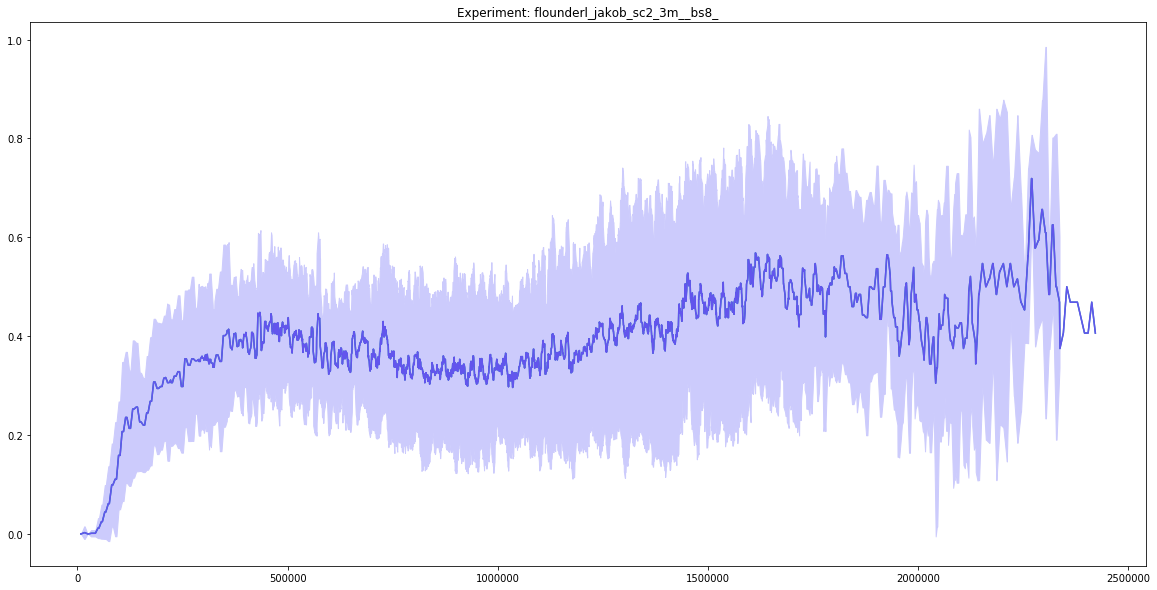

In [13]:
# for k, v in tag_dict.items():
d1 = plot_bundle(bad3, mongo_central, prop="Win rate test", mode="individual")


/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



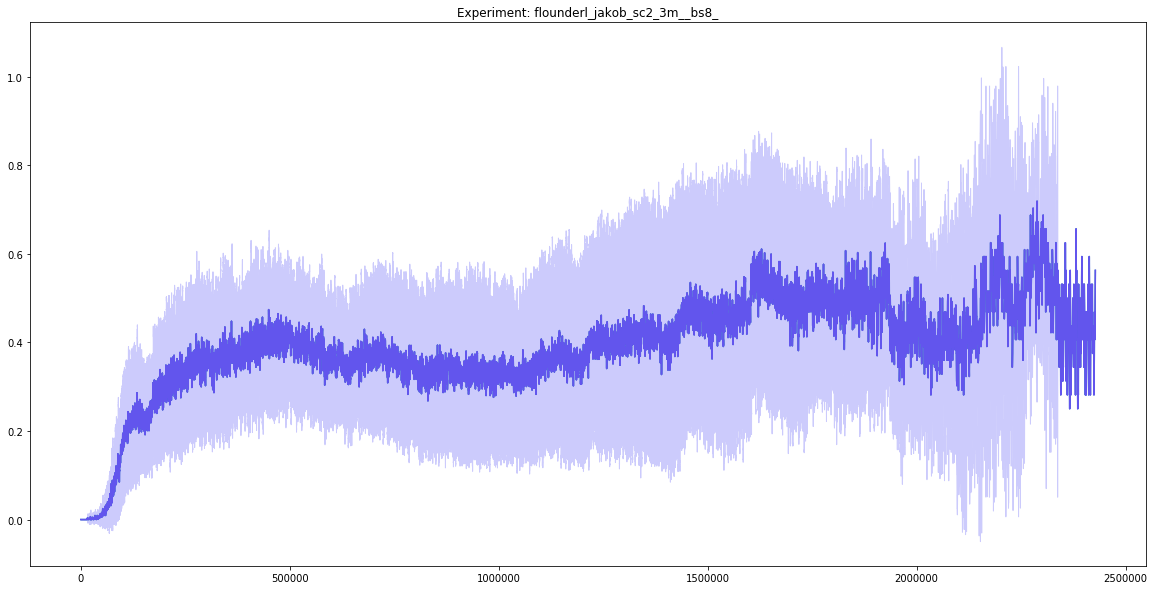

In [12]:
# for k, v in tag_dict.items():
d1 = plot_bundle(bad3, mongo_central, prop="Win rate", mode="individual")


/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



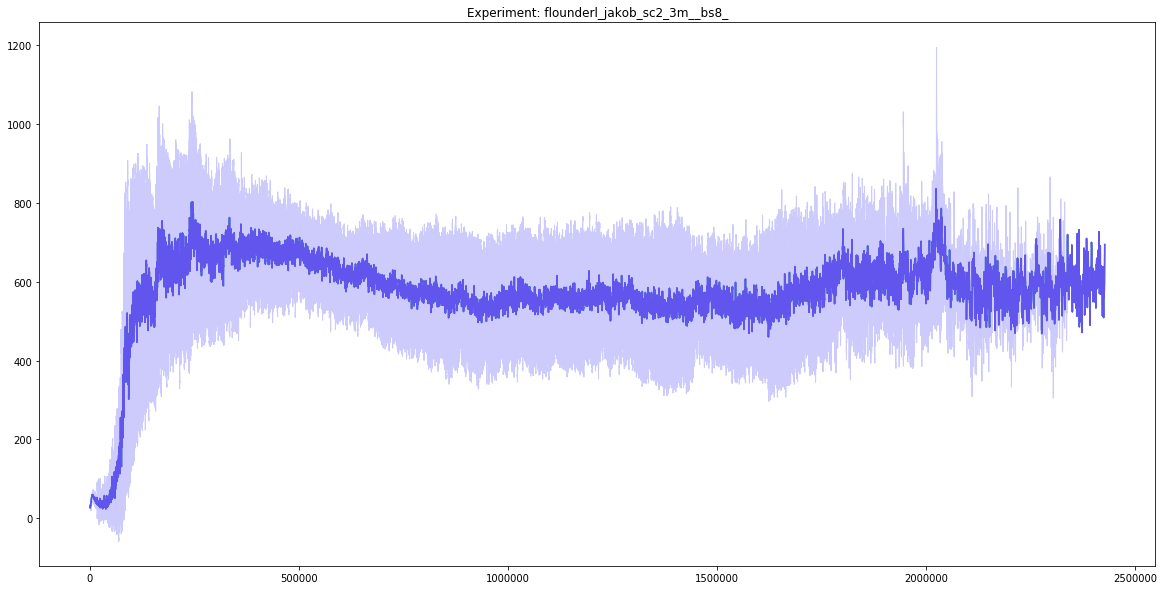

In [19]:
d1 = plot_bundle(bad3, mongo_central, prop="Critic loss level1", mode="individual")

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



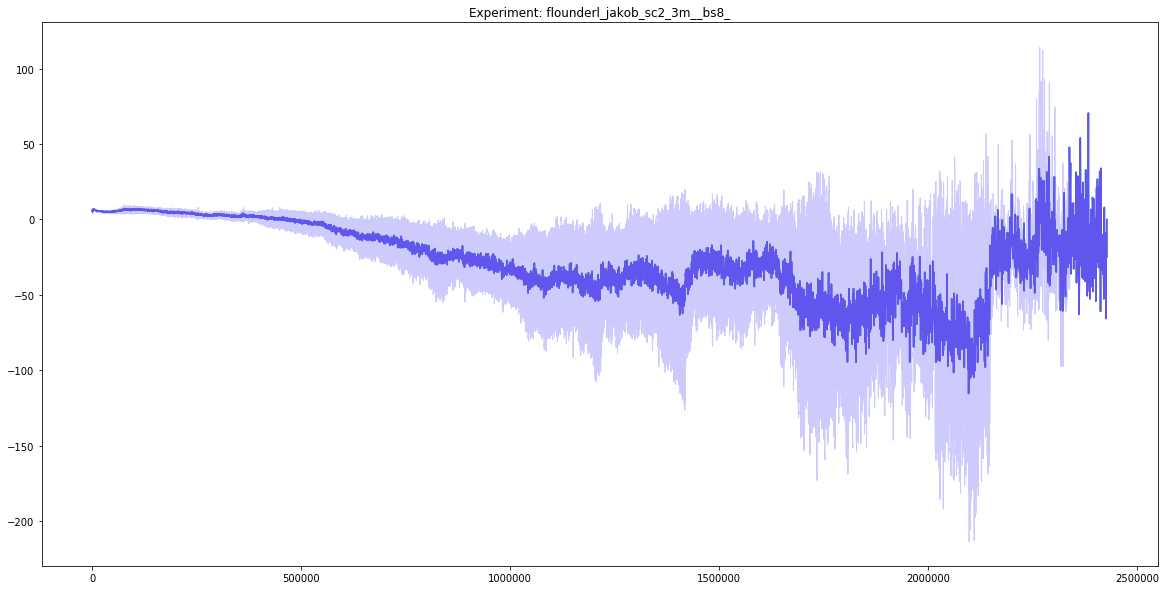

In [20]:
d1 = plot_bundle(bad3, mongo_central, prop="Policy loss level1", mode="individual")

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



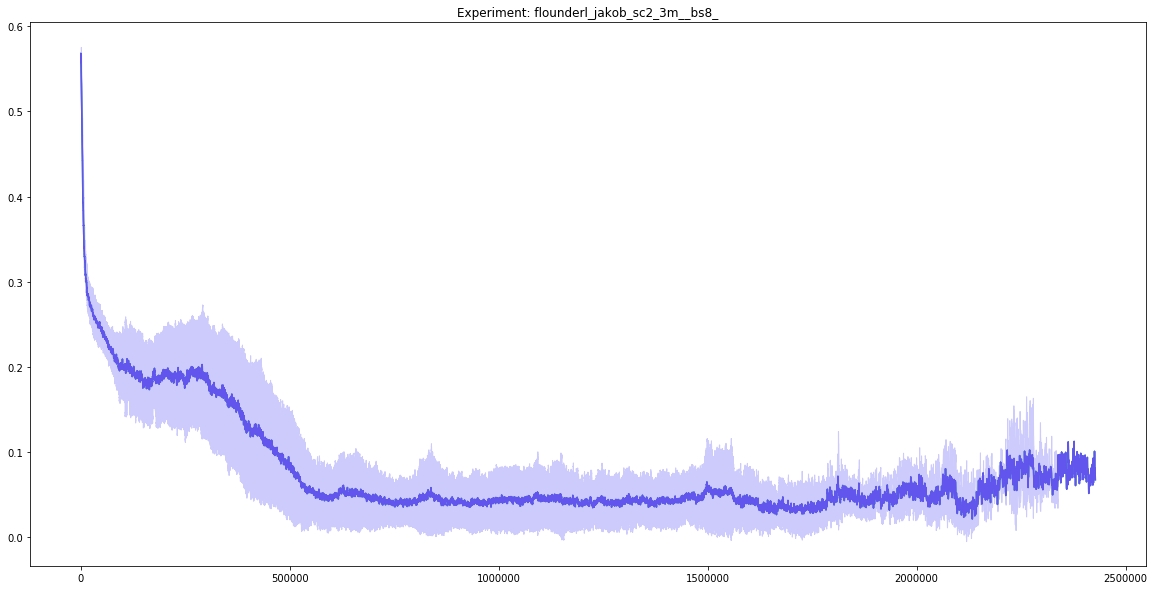

In [21]:
d1 = plot_bundle(bad3, mongo_central, prop="Policy level1 entropy", mode="individual")

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



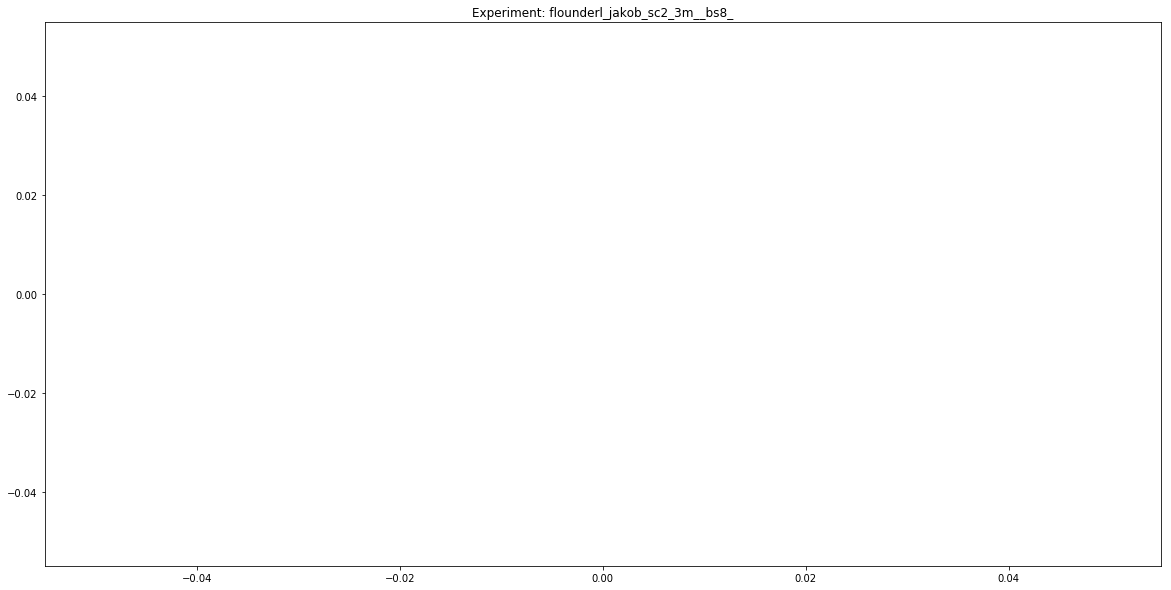

In [22]:
d1 = plot_bundle(bad3, mongo_central, prop="Level2 delegation rate test", mode="individual")

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



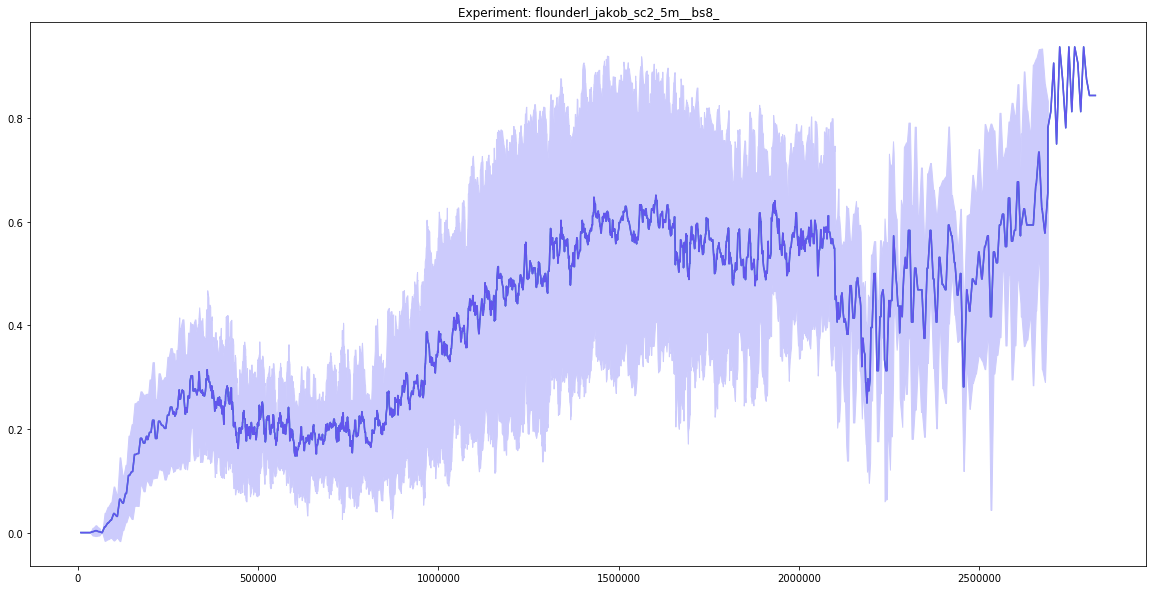

In [23]:
# for k, v in tag_dict.items():
d1 = plot_bundle(bad5, mongo_central, prop="Win rate test", mode="individual")

/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



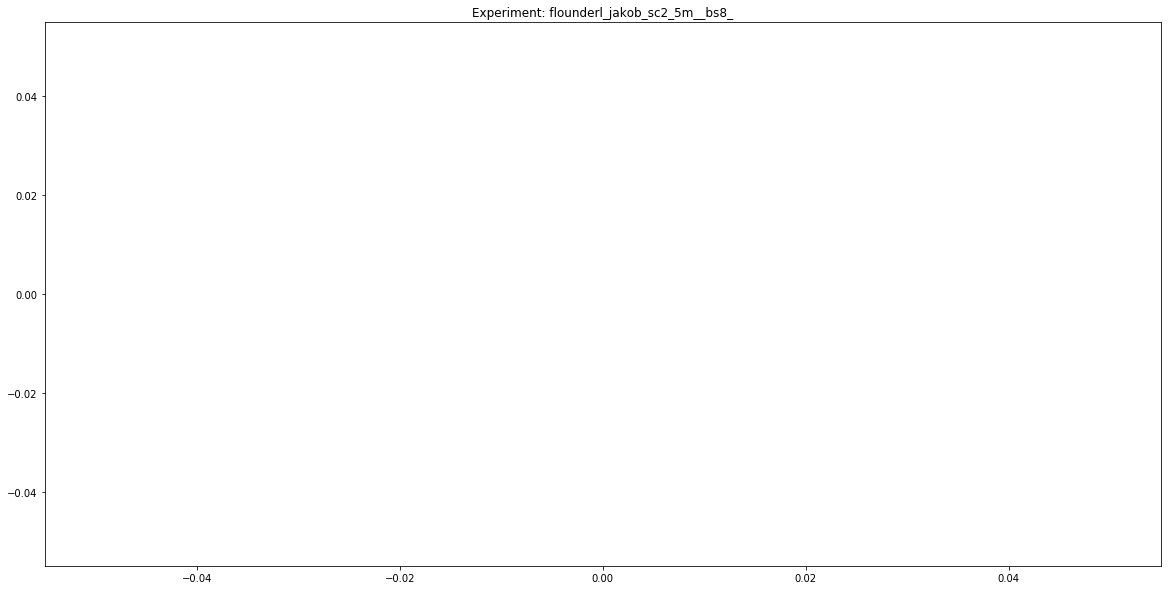

In [24]:
d1 = plot_bundle(bad5, mongo_central, prop="Level2 delegation rate test", mode="individual")

Done Loading...


/home/cs/Documents/pymarl/venv/pymarl/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



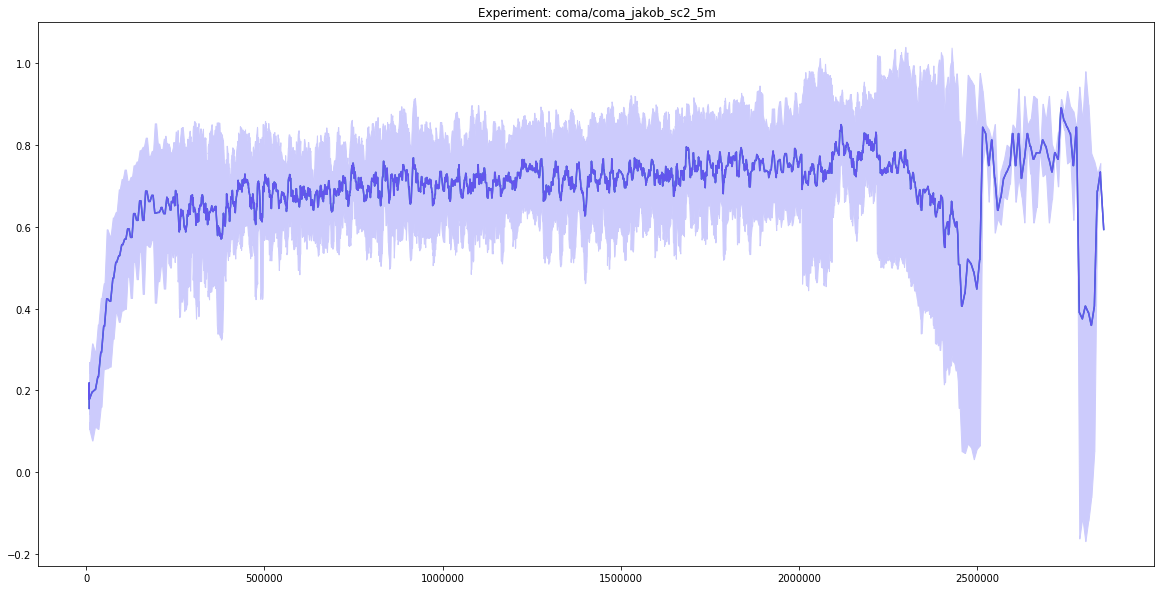

In [26]:
cjak2 = mongo_central.get_tag_names("CJAK2")
d1 = plot_bundle(cjak2, mongo_central, prop="Win rate test", mode="individual")